In [7]:
# Import required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp

In [9]:
# Set time range of 24 years
t = pd.date_range(start='31/10/2000', end='31/10/2024', freq='ME')

# Define column names for the equities
equity_columns = [
    'JOHNSON & JOHNSON',
    'BOSTON SCIENTIFIC',
    'ELI LILLY',
    'PFIZER', 
    'TELEFLEX',
    'CIGNA',
    'REVVITY',
    'MEDTRONIC', 
    'LABCORP HOLDINGS',
    'HUMANA'
    ]
    
# Generate lists for total return indices and market value indices
equity_TRI_columns = [f"{name} - TOT RETURN IND" for name in equity_columns]
equity_MV_columns  = [f"{name} - MARKET VALUE"   for name in equity_columns]

In [11]:
import os
os.chdir('/Users/enricopaciaroni/Desktop/UNIPD/24-25/RTS/CAPM/G2/DATA')

In [13]:
FF5 = pd.read_excel('FF5.xlsx')
CPI = pd.read_excel('CPI.xlsx')

MKT = pd.read_excel('FF5.xlsx', usecols=['Mkt-RF'])
SMB = pd.read_excel('FF5.xlsx', usecols=['SMB'])
HML = pd.read_excel('FF5.xlsx', usecols=['HML'])
CMA = pd.read_excel('FF5.xlsx', usecols=['CMA'])
RMW = pd.read_excel('FF5.xlsx', usecols=['RMW'])
OIL = pd.read_excel('CPI.xlsx', usecols=['OIL'])
CPI = pd.read_excel('CPI.xlsx', usecols=['CPI'])
PPI = pd.read_excel('CPI.xlsx', usecols=['PPI CHEMICAL'])
IND_PROD = pd.read_excel('CPI.xlsx', usecols=['US INDUSTRIAL PRODUCTION - MANUFACTURING (NAICS) VOLA'])

logCPI = 100 * (np.log(CPI) - np.log(CPI.shift(1)))
logIND_PROD = 100 * (np.log(IND_PROD) - np.log(IND_PROD.shift(1)))

In [14]:
# Interest rates

# Download risk free interest rates (skipping rows 1,2 because they are not actual market values but additional information)
rF_yearly = pd.read_excel('INTEREST RATE.xlsx', usecols=['US FEDERAL FUNDS RATE (MONTHLY AVERAGE) NADJ'], header=0)

# Verify there are no NaN values in the DataFrame
assert not rF_yearly.isnull().values.any(), "DataFrame contains NaN values"

# Compute monthly rates
rF = np.array(rF_yearly / 12)

In [15]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Market indices

# Download overall equity market index
health_MKT = pd.read_excel('STOXX HEALTH PI.xlsx', usecols=['STOXX NTH AMER 600 HEALTH CARE E - PRICE INDEX'])

# Verify there are no NaN values in the DataFrame
assert not health_MKT.isnull().values.any(), "DataFrame contains NaN values"

# Conversion in percentual montlhy variance
rMKT = 100 * (np.log(health_MKT) - np.log(health_MKT.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
# Calculation of Excess Market Returns from risk-free Market Returns
rMKT = np.array(rMKT[1:])
eMKT = np.subtract(rMKT, rF[1:])

#-----------------------------------------------------------------------------------------------------------------------------------#
# Market value of constituents

# Download market value of constituents
mkt_value = pd.read_excel('MKT VALUE.xlsx', usecols=equity_MV_columns, header=0)
# Reorder the columns explicitly to match the correct order 
mkt_value = mkt_value[equity_MV_columns]

# Verify there are no NaN values in the DataFrame
assert not mkt_value.isnull().values.any(), "DataFrame contains NaN values"

#-----------------------------------------------------------------------------------------------------------------------------------#
# Equities

# Download equities
data = pd.read_excel('Stocks_Constituents.xlsx', usecols=equity_TRI_columns)
# Reorder the columns explicitly to match the correct order 
data = data[equity_TRI_columns]
# Verify there are no NaN values in the DataFrame
assert not data.isnull().values.any(), "DataFrame contains NaN values"

In [18]:
# Calculate the log returns for all equities
log_returns = 100 * (np.log(data) - np.log(data.shift(1)))

# Drop the first row (since log returns are computed as difference between consecutive data, first row will be NaN)
log_returns = log_returns.iloc[1:]

# Verify there are no other NaN values in the DataFrame
assert not log_returns.isnull().values.any(), "DataFrame contains NaN values"

# Broadcasting rF across columns in log_return to create the result dataframe
eEquities = log_returns.sub(rF[1:], axis=0)

In [21]:
# Adds an intercept (constant) term to eMKT
eMKT_with_const   = sm.add_constant(eMKT)

In [23]:
#-----------------------------------------------------------------------------------------------------------------------------------#
# Perform linear regression on the portfolio

# Compute the weights
weights           = mkt_value.div(mkt_value.sum(axis=1), axis=0)
# Rename columns in both DataFrames so that pandas doesn't cry when performing element-wise multilpication 
weights.columns   = equity_columns
eEquities.columns = equity_columns
# Compute weighted average
avg_return        = weights[1:] * eEquities
# Sum across columns to get the portfolio return for each row
ePortfolio        = avg_return.sum(axis=1)


In [203]:
Y = ePortfolio
X = np.column_stack((np.ones_like(ePortfolio) , eMKT, MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))
Res1 = sm.OLS(Y , X).fit()
print(Res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     107.7
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.14e-88
Time:                        16:09:22   Log-Likelihood:                -589.55
No. Observations:                 284   AIC:                             1201.
Df Residuals:                     273   BIC:                             1241.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4405      0.530     -0.831      0.4

In [193]:
resid1=Res1.resid

In [195]:
datas = np.column_stack((eMKT, MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]))

In [197]:
df = pd.DataFrame(datas, columns=['eMKT', 'MKT', 'SMB', 'HML', 'RMW', 'CMA', 'logCPI', 'OIL', 'PPI', 'logIND_PROD'])

In [199]:
correlation_matrix = df.corr()

In [201]:
print(correlation_matrix)

                 eMKT       MKT       SMB       HML       RMW       CMA  \
eMKT         1.000000  0.712064  0.128834 -0.010545 -0.228600 -0.073611   
MKT          0.712064  1.000000  0.302923  0.052568 -0.360059 -0.176050   
SMB          0.128834  0.302923  1.000000  0.296990 -0.307806  0.090275   
HML         -0.010545  0.052568  0.296990  1.000000  0.136276  0.599323   
RMW         -0.228600 -0.360059 -0.307806  0.136276  1.000000  0.147279   
CMA         -0.073611 -0.176050  0.090275  0.599323  0.147279  1.000000   
logCPI       0.037094  0.020581  0.007841  0.143097  0.005832  0.030110   
OIL          0.087372  0.027635 -0.082581  0.035398 -0.008219 -0.048774   
PPI          0.081173  0.072622 -0.147545 -0.064782 -0.009588 -0.097024   
logIND_PROD -0.095568  0.025593  0.012944  0.045575 -0.045536  0.031956   

               logCPI       OIL       PPI  logIND_PROD  
eMKT         0.037094  0.087372  0.081173    -0.095568  
MKT          0.020581  0.027635  0.072622     0.025593  
SMB

In [ ]:
X = np.column_stack((np.ones_like(ePortfolio), eMKT, MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))


In [207]:
Res2 = sm.OLS(Y , X).fit()

In [209]:
print(Res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     211.6
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.50e-92
Time:                        16:09:57   Log-Likelihood:                -593.57
No. Observations:                 284   AIC:                             1199.
Df Residuals:                     278   BIC:                             1221.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1628      0.119      1.365      0.1

In [212]:
RSSU = Res1.ssr
RSSR = Res2.ssr
Fstat =(( RSSR - RSSU ) /5) /( RSSU /(273) )
Pval =1 - sp.stats.f.cdf(Fstat, 5, 273)
print(f"p-value={Pval}")

p-value=0.16946250825473175


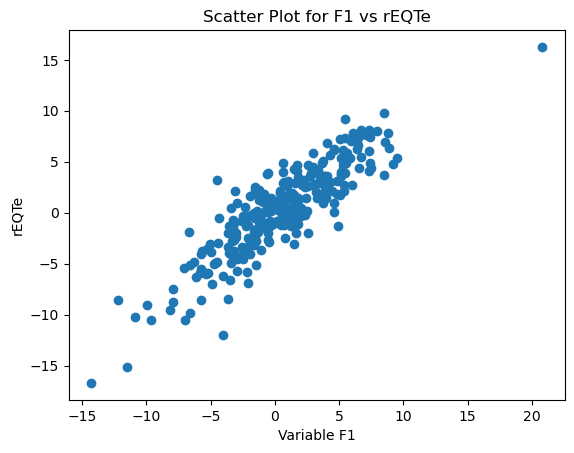

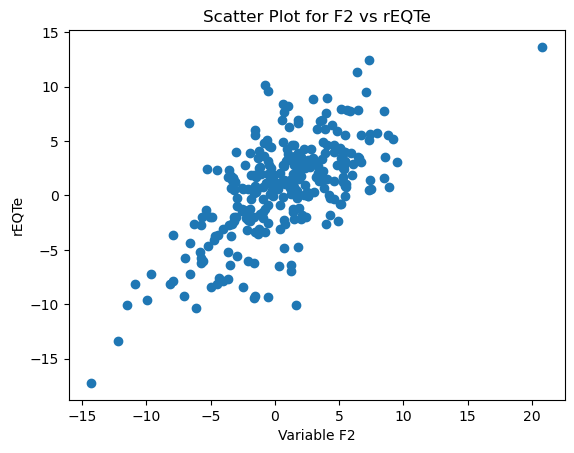

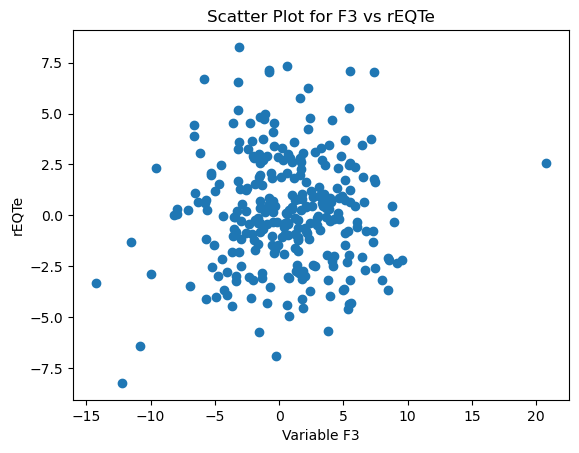

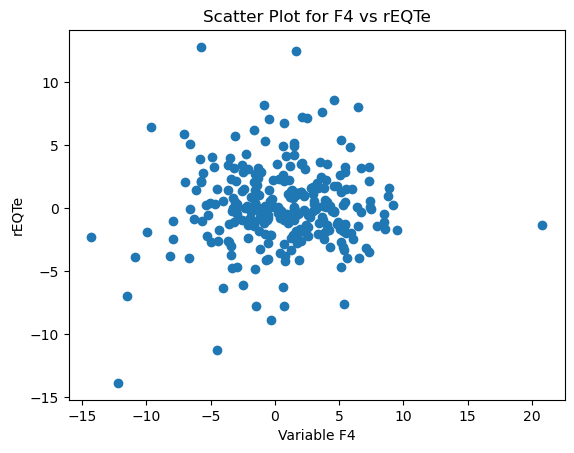

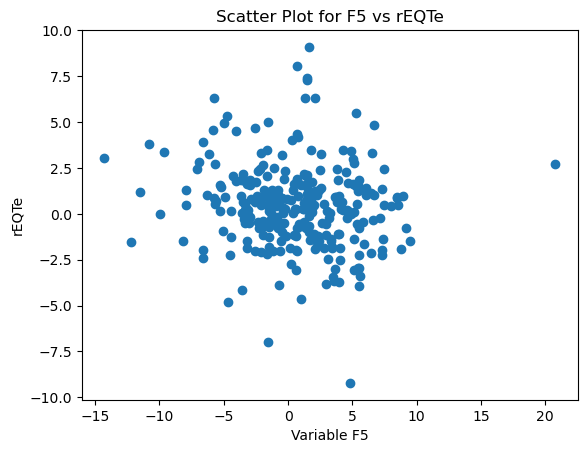

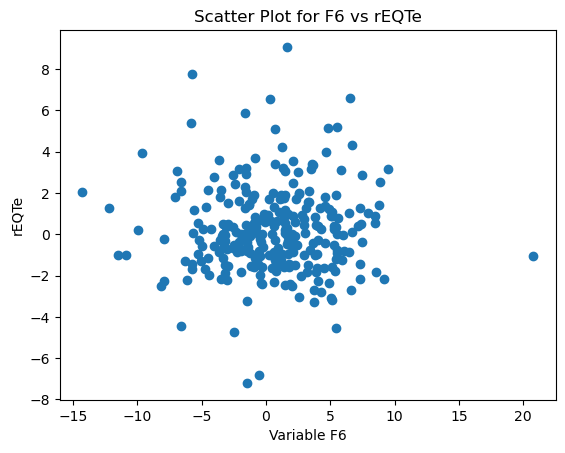

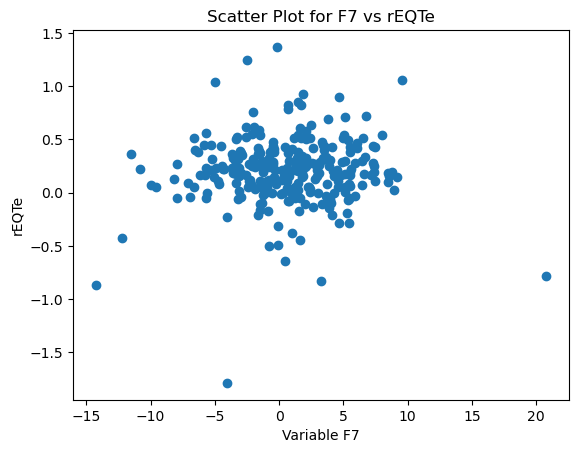

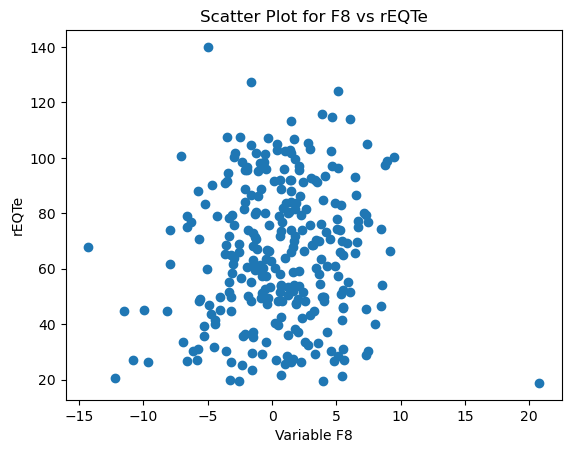

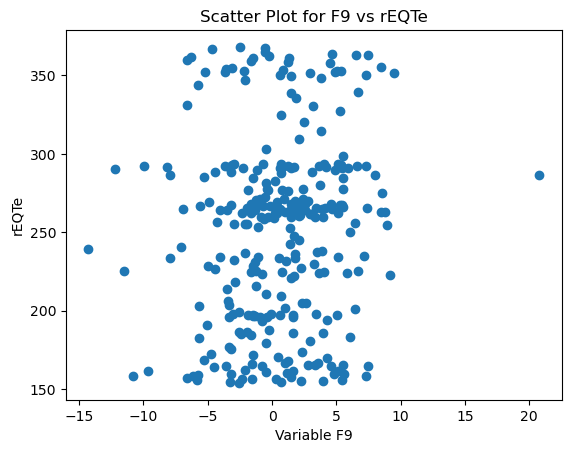

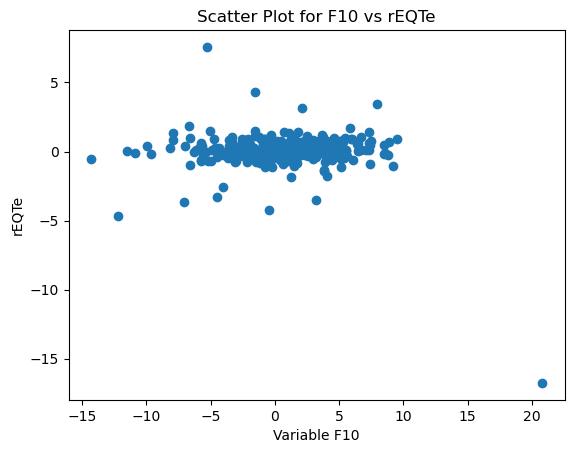

In [216]:
list_scatter= [ eMKT, MKT[1:], SMB[1:] , HML[1:] , RMW[1:], CMA[1:], logCPI[1:], OIL[1:], PPI[1:], logIND_PROD[1:]]
for i, element in enumerate(list_scatter):
    plt.scatter(ePortfolio,element)
    plt.title(f'Scatter Plot for F{i+1} vs rEQTe')
    plt.xlabel(f'Variable F{i+1}')
    plt.ylabel("rEQTe")
    plt.show()

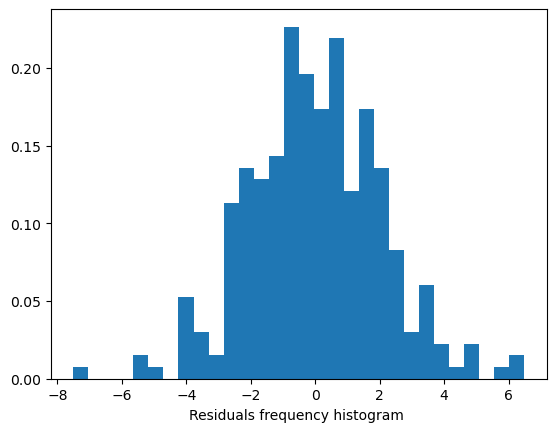

In [218]:
X =np.column_stack((np.ones_like(eMKT), eMKT))
Res1 = sm.OLS(ePortfolio ,X).fit()
rs1 = Res1.resid
# frequency histogram
plt.hist(rs1, bins=30 , density = True )
plt.xlabel('Residuals frequency histogram ')
plt.show()

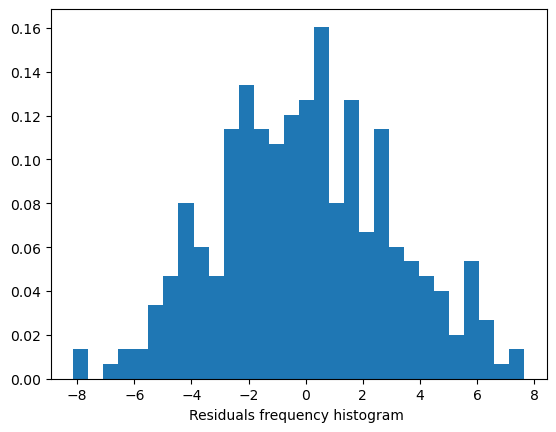

In [220]:
X =np.column_stack((np.ones_like(ePortfolio), MKT[1:], SMB[1:], CMA[1:], logIND_PROD[1:]))
Res2 = sm.OLS(ePortfolio, X).fit()
rs2 = Res2.resid
# frequency histogram
plt.hist(rs2, bins=30 , density = True )
plt.xlabel('Residuals frequency histogram ')
plt.show()

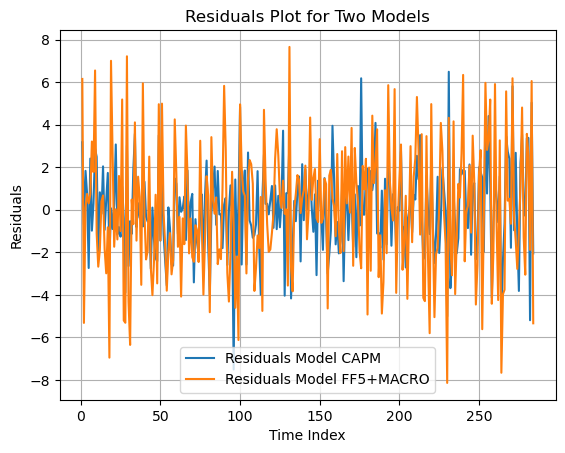

Correlation: 0.5239813058492413


In [222]:
plt.plot(rs1, label='Residuals Model CAPM')
plt.plot(rs2, label='Residuals Model FF5+MACRO')
plt.title('Residuals Plot for Two Models')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()
# Compute the correlation between residuals
correlation_res = np.corrcoef(rs1, rs2)[0, 1]
print(f"Correlation: {correlation_res}")

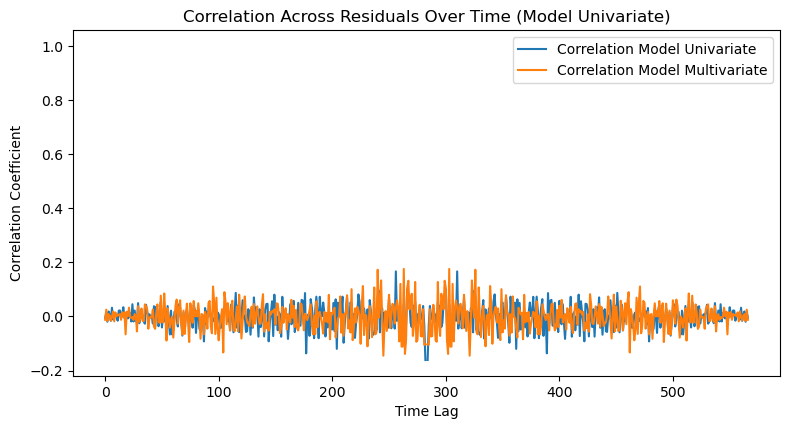

In [224]:
# Calculate the correlation coefficients at each time point for each model
correlation_across_time_model1 = np.correlate(rs1, rs1, mode='full')
correlation_across_time_model2 = np.correlate(rs2, rs2, mode='full')

# Exclude a small neighborhood around the central peak by setting it to NaN

# Normalize the correlation coefficients, excluding NaN values
normalized_correlation_model1 = correlation_across_time_model1 / np.nanmax(np.abs(correlation_across_time_model1))
normalized_correlation_model2 = correlation_across_time_model2 / np.nanmax(np.abs(correlation_across_time_model2))

# Visualize the correlation across residuals over time for each model
plt.figure(figsize=(8, 8))

# Plot correlation across residuals over time for Model 1
plt.subplot(2, 1, 2)
plt.plot(normalized_correlation_model1, label='Correlation Model Univariate')
plt.plot(np.arange(len(normalized_correlation_model2)), normalized_correlation_model2, label='Correlation Model Multivariate')
plt.title('Correlation Across Residuals Over Time (Model Univariate)')
plt.xlabel('Time Lag')
plt.ylabel('Correlation Coefficient')
plt.legend()

#In the midpoint it creates outliers due to its construction, so it was added this for loop that eliminate outliers from the 
#central point of the graph
for ax in plt.gcf().get_axes():
    for line in ax.get_lines():
        y_data = line.get_ydata()
        x_data = line.get_xdata()
        line.set_ydata(np.where(y_data > 0.3, np.nan, y_data))

plt.tight_layout()
plt.show()